In [94]:
from functools import partial
from numbers import Complex
from typing import Callable
from math import pi, e

import PIL
import glob
import imageio
import matplotlib.pyplot as plt 
import numpy as np


In [95]:
def douady_hubbard_polynomial(z: Complex,
                              c: Complex) -> Complex:
    """
    Monic and centered quadratic complex polynomial
    https://en.wikipedia.org/wiki/Complex_quadratic_polynomial#Map
    """
    return z ** 2 + c

In [96]:
def Circle_Path(radius, iterations):
    r = radius
    c_n = []
    circle = 2*pi
    for t in range(iterations):
        c = r*e**(t * circle/iterations * 1j)
        c_n.append(c)
    return c_n

In [97]:
def julia_set(mapping: Callable[[Complex], Complex], 
            *, 
            min_coordinate: Complex, 
            max_coordinate: Complex, 
            width: int, 
            height: int, 
            iterations_count: int = 256, 
            threshold: float = 2.) -> np.ndarray:
    im, re = np.ogrid[min_coordinate.imag: max_coordinate.imag: height * 1j, min_coordinate.real: max_coordinate.real: width * 1j]

    z = (re + 1j * im).flatten()

    live, = np.indices(z.shape)
    iterations = np.empty_like(z, dtype=int)
    
    for i in range(iterations_count):
        z_live = z[live] = mapping(z[live])
        escaped = abs(z_live) > threshold
        iterations[live[escaped]] = i
        live = live[~escaped]
        if live.size == 0:
            break
    else: 
        iterations[live] = iterations_count

    return iterations.reshape((height, width))

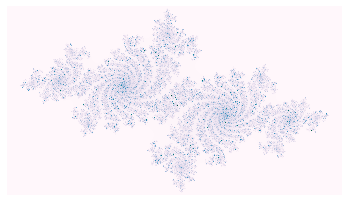

In [98]:
mapping = partial(douady_hubbard_polynomial, c=-0.7 + 0.27015j)
image = julia_set(mapping, min_coordinate=-1.6-0.9j, max_coordinate=1.6+0.9j,width=1920, height=1080, iterations_count= 2048)
plt.axis('off')
plt.imshow(image, cmap='PuBuGn', origin='lower')
plt.show()

In [99]:
def animator(Gif_out):
    with imageio.get_writer(Gif_out, mode='I') as writer:
        filenames = glob.glob('plot*.png')
        filenames = sorted(filenames)
        print(filenames)
        last = -1
        for i, filename in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else: 
                continue
            image = imageio.imread(filename)
            writer.append_data(image)

In [110]:
def generate_images(func, radius:int , iters: int, width, height, min_coord: Complex, max_coord: Complex, cmap, iterations_count = 256):
    
    c_n = Circle_Path(radius, iters)

    for i in range(iters):
        mapping = partial(func, c = c_n[i])

        image = julia_set(mapping, 
                min_coordinate= min_coord, 
                max_coordinate= max_coord, 
                width=width, 
                height=height,
                iterations_count=iterations_count)
        plt.axis('off')
        plt.imshow(image, cmap=cmap, origin = 'lower')
        plt.savefig('plot_{:04d}.png'.format(i), dpi=400)

In [101]:
def sample_plot(func, width, height, min_coord, max_coord):
    
    c_n = Circle_Path(1, 16)
    examples = []
    for i in range(16): 
        mapping = partial(func, c = c_n[i])
        example = julia_set(mapping, 
        min_coordinate=min_coord, 
        max_coordinate=max_coord,
        width=width,
        height=height)
        examples.append(example)
        
    
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.axis('off')
        plt.subplot(4,4, i+1)
        plt.imshow(examples[i], cmap='PuBuGn', origin= 'lower')
    plt.show()

In [102]:
def tan_func(z: Complex, c: Complex) -> Complex:
    return np.tan(z) ** 3 + c

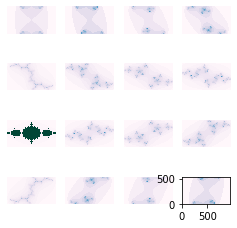

In [103]:
sample_plot(douady_hubbard_polynomial,960,540,-1.5-1j,1.5+1j)

In [111]:
func = lambda z, c : np.tan(z) ** 3 + c
generate_images(douady_hubbard_polynomial,1,200,3840,2880,-2-1.5j,2+1.5j,"PuBuGn",2048)
Gif_out = 'douady_2.gif'
animator(Gif_out)

In [25]:
def mandelbrot_set(func, max_iters, width, height, min_coord, max_coord, horizon):
    im, re = np.ogrid[min_coord.imag: max_coord.imag: height * 1j, min_coord.real: max_coord.real: width * 1j]
    c = (re + 1j * im).flatten()
    n = np.zeros(c.shape, dtype = int)
    z = np.zeros(c.shape, np.complex64)
    for j in range(max_iters):
        i = np.less(abs(z), horizon)
        n[i] = j
        z[i] = func(z[i], c[i])
    n[n==max_iters-1] = 0
    return z,n
    
def plot_mandelbrot(func, max_iters, width, height, min_coord, max_coord, horizon, dpi, cmap):
    z,n = mandelbrot_set(func, max_iters, width, height, min_coord, max_coord, horizon)
    log_horizon = np.log(np.log(horizon))/np.log(2)
    with np.errstate(invalid='ignore'):
        mandelbrot = np.nan_to_num(n + 1 - np.log(np.log(abs(z)))/np.log(2) + log_horizon)
    mandelbrot = np.expand_dims(mandelbrot, axis= -1)
    mandelbrot = mandelbrot.reshape((height, width))
    fig = plt.figure(dpi = dpi)
    plt.axis('off')
    plt.imshow(mandelbrot, interpolation='nearest', cmap=cmap)



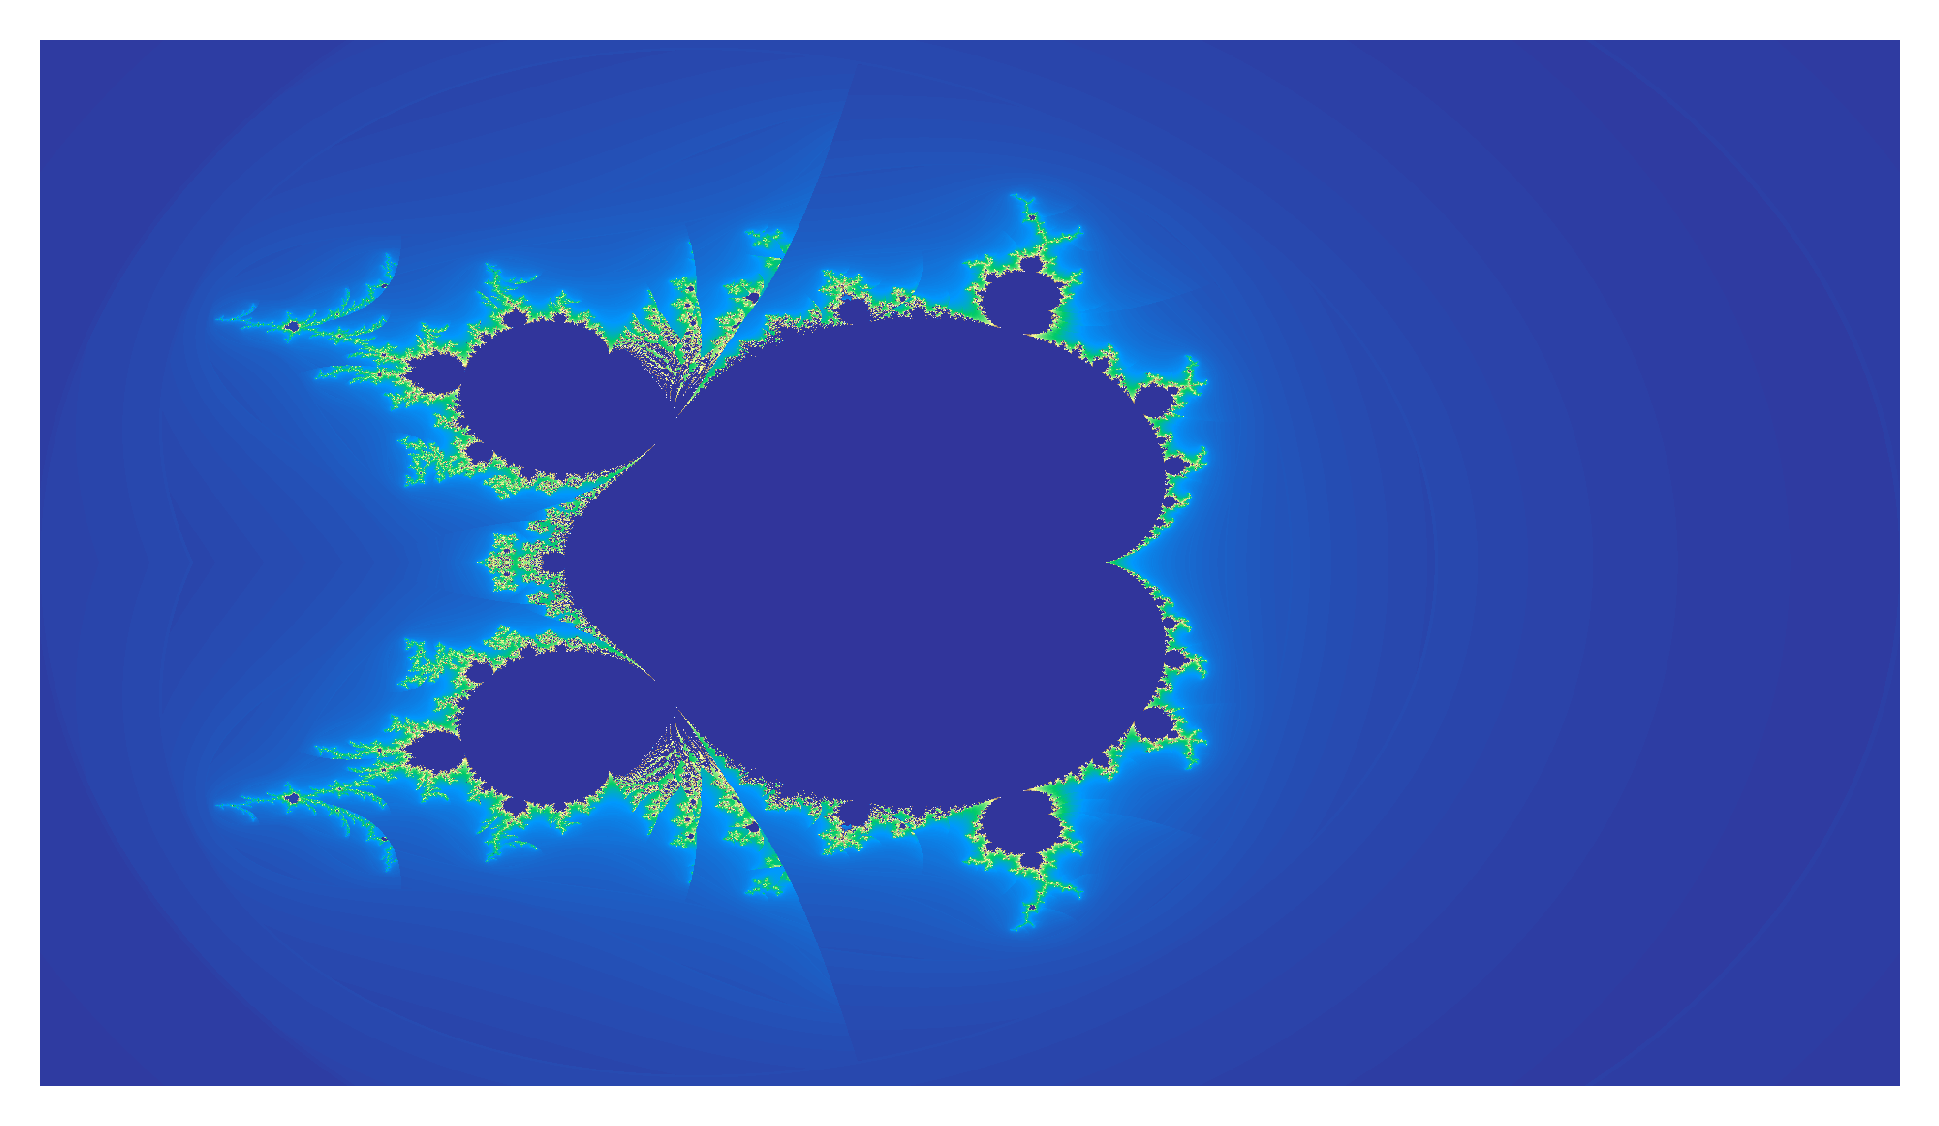

In [61]:
func2 = lambda z, c : z ** 2.2 + c

plot_mandelbrot(func2,64,1920,1080,-2-1.5j,2+1.5j,2.0, 400, 'terrain')